In [2]:
from airpy.agd import * # age+gender predict data
from airpy.merge import * # sessions merged data
from airpy.data import * # classification data

---

In [3]:
check, pre_age = pre_age_set_data()

In [ ]:
pre_gen_mission_test, pre_gen_train_test, pre_gen_mission, pre_gen_train, \
            pre_gen_mission_test_drop, pre_gen_train_test_drop = pre_gen_predict_data()

In [ ]:
model_gen_lgb = predict_gen_LightGBM()

In [ ]:
model_gen_lgb.to_csv("model_gen_lgb.csv", index=False)

In [ ]:
pre_age_mission_test, pre_age_train_test, pre_age_mission, pre_age_train, \
            pre_age_mission_test_drop, pre_age_train_test_drop = pre_age_predict_data()

In [ ]:
cats = pre_age_predict_data_cat()

In [ ]:
model_age_lgb = predict_age_LightGBM()

In [ ]:
model_age_lgb.to_csv("model_age_lgb.csv", index=False)

---

In [ ]:
merged_sessions = make_merged_sessions()

In [ ]:
merged_sessions = remove_word()

In [ ]:
merged_sessions = sessions_detail_add()

---

In [ ]:
check, pre_age = pre_age_set_data()

In [ ]:
pre_age_mission_test, pre_age_train_test, pre_age_mission, pre_age_train, \
            pre_age_mission_test_drop, pre_age_train_test_drop = pre_age_predict_data()

In [ ]:
cats = pre_age_predict_data_cat()

In [ ]:
last_gen_add = add_gender()

In [ ]:
add_hol = holiday()

In [ ]:
last_train_data, last_test_data, y_label, le = predict_age_add()

In [ ]:
last_train_data_add, last_test_data_add = last_data_setting()

___

# Project : Airbnb New User Booking
---

### Abstract :  

- purpose of prediction

- Model

- Score


### Introduction :

- purpose of analysis : Predict destination country

- evaluation metric : NDCG (Normalized discounted cumulative gain)

- evaluation question : 


### Methods :

- Description of selected model :

- comparision of selected model and other method :

- feature engineering : 

        - train / test missing data : 
        
        - train / test categorical data :
        
        - sessions :
        
        - dropped data : age bkts, countries

### Conclusions :

##### A. Summary of Key Findings:

##### B. Final Analysis :
- * How does the author understand the data
- * How does the author believe the data will impact the program
- * Strengths and weaknesses of the program as revealed by evaluation findings 

##### C. Issues for Further Consideration (any outstanding issues raised by the evaluation) 

### 1. Introduction :

- purpose of analysis : Predict destination country

- evaluation metric : NDCG (Normalized discounted cumulative gain)


$$
DCG_k=\sum_{i=1}^k\frac{2^{rel_i}-1}{\log_2{\left(i+1\right)}}
$$

$$
nDCG_k=\frac{DCG_k}{IDCG_k}
$$


#### Methods :

- Description of selected model :

- comparision of selected model and other method :

- feature engineering : 

        - train / test missing data : 
                
                - date_first_booking : dropped
                
                - age : filled by clustering age buckets
                
                - first_affiliate_tracked : filled by mode data
        
        - train / test categorical data : 
        
                - one-hot encoding
        
        - sessions :
        
                - action
                
                - action type
                
                - secs elapsed time
        
        - other features :
        
                - etc
                
                - etc
        
        - dropped data : age bkts, countries


#### Load data

In [1]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
df_train = pd.read_csv("../data/train_users_2.csv")
df_test = pd.read_csv("../data/test_users.csv")
df_all = pd.concat([df_train, df_test])
df_countries = pd.read_csv('../data/countries.csv')
df_sessions = pd.read_csv('../data/sessions.csv')
df_age_bkts = pd.read_csv('../data/age_gender_bkts.csv')

#### Missing value

In [12]:
df_all.drop("country_destination", axis = 1, inplace = True)

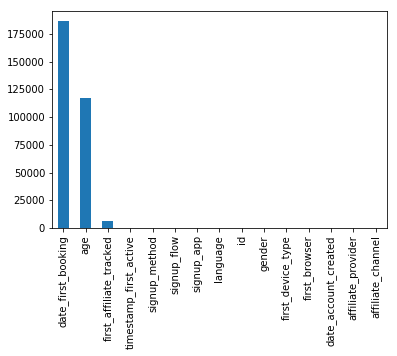

In [13]:
df_all.isnull().sum().sort_values(ascending = False).plot(kind="bar")

In [14]:
print('Missing data ratio')
print('date_frist_booking :',round(df_all.date_first_booking.isnull().sum() / len(df_all) * 100, 2))
print('age :',round(df_all.age.isnull().sum() / len(df_all) * 100, 2))
print('first_affiliate_tracked:',round(df_all.first_affiliate_tracked.isnull().sum() / len(df_all) * 100, 2))

Missing data ratio
date_frist_booking : 67.73
age : 42.41
first_affiliate_tracked: 2.21


#### (3) Explore Target

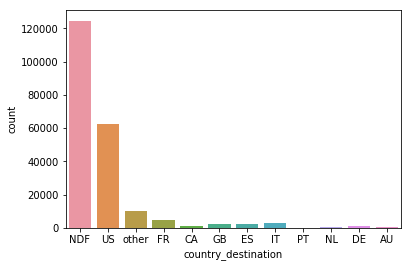

In [15]:
sns.countplot(df_train["country_destination"])

In [22]:
round(df_train["country_destination"].value_counts() / len(df_train) * 100, 2)

NDF      58.35
US       29.22
other     4.73
FR        2.35
IT        1.33
GB        1.09
ES        1.05
CA        0.67
DE        0.50
NL        0.36
AU        0.25
PT        0.10
Name: country_destination, dtype: float64

### 3. Feature Engineering

#### (1) Impute featrues

##### 1-1. Gender

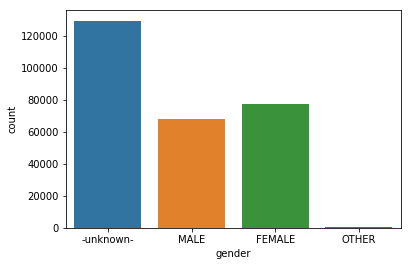

In [36]:
sns.countplot(df_all["gender"])

- female - male 

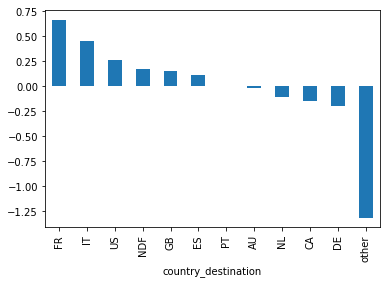

In [42]:
df_train["count"] = 1
df_gender_country = df_train.pivot_table(values = "count", index = ["country_destination"], columns = ["gender"], aggfunc=np.sum)
df_gender_country["FEMALE"] = df_gender_country["FEMALE"] / df_gender_country["FEMALE"].sum() * 100
df_gender_country["MALE"] = df_gender_country["MALE"] / df_gender_country["MALE"].sum() * 100
(df_gender_country["FEMALE"] - df_gender_country["MALE"]).sort_values(ascending = False).plot(kind="bar")

- 여자는 FR, IT 주로 여행을 간다. 
- 남자는 DE, other를 주로 여행을 간다

##### 1-2. Age

In [201]:
labels = ["0:0-27", "1:27-31", "2:31-36", "3:36-46", "4:46-"]

In [202]:
df_train["age_cut"] = pd.qcut(df_train[df_train["age"] <= 120]['age'], 5, labels = labels)

In [203]:
df_age_pivot = df_train.pivot_table(values = "count", index = "age_cut", columns = "country_destination", aggfunc = np.sum, fill_value = 0)

In [204]:
df_age_pivot

country_destination,AU,CA,DE,ES,FR,GB,IT,NDF,NL,PT,US,other
age_cut,,,,,,,,,,,,
0:0-27,65,174,186,448,695,351,437,12255,150,36,9808,1471
1:27-31,97,224,160,312,681,296,340,9995,102,35,10250,1550
2:31-36,78,219,159,373,738,336,429,10630,131,35,10561,1665
3:36-46,111,243,176,298,810,357,392,12083,111,23,9715,1521
4:46-,84,211,163,266,770,424,425,11561,103,28,8009,1324


In [207]:
for c in df_age_pivot.index:
    df_age_pivot.loc[c] = (df_age_pivot.loc[c] / (df_train["age_cut"] == c).sum() * 100)

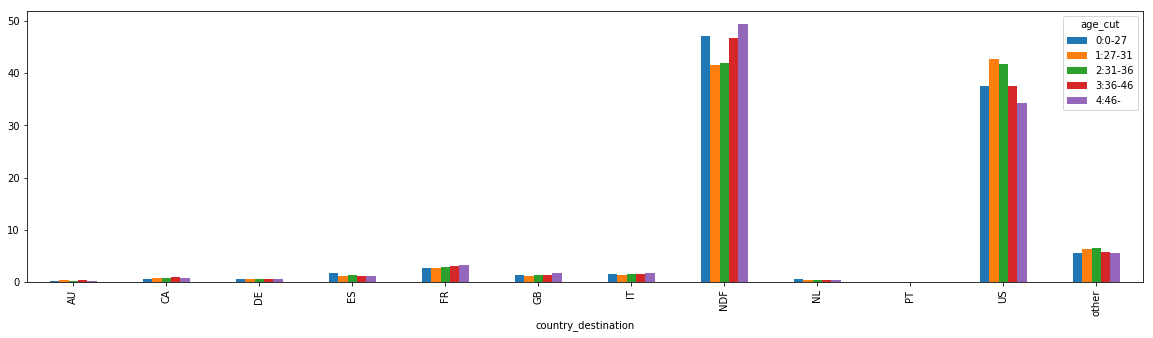

In [208]:
df_age_pivot.T.plot(kind = "bar", figsize = (20, 5))

(0, 4)

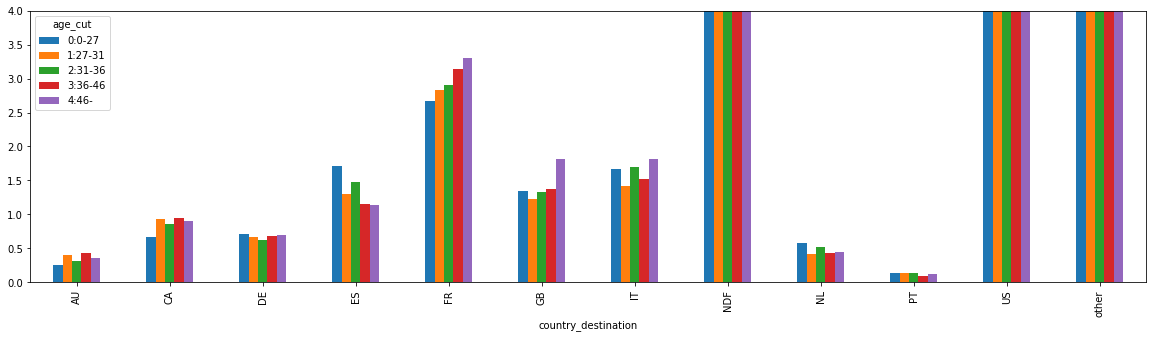

In [210]:
df_age_pivot.T.plot(kind = "bar", figsize = (20, 5))
plt.ylim([0,4])

- NDF : 27-36세는 NDF가 아닐 확률이 높다.
- US  : 27-36세는 US로 여행할 확률이 높다.
- FR  : 나이가 늘어 날수록 여행갈 비율이 높다.
- other : 27-36세는 other에 여행할 확률이 약간 높다.
- GB  : 46-세는 GB에 여행갈 확률이 높다
- ES  : 0-27세는 ES에 여행갈 확률이 높다.

##### 1-3. first_affiliate_tracked

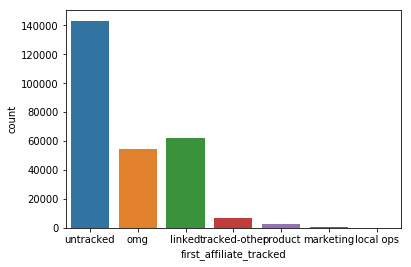

In [27]:
sns.countplot(df_all["first_affiliate_tracked"])

In [30]:
df_all["first_affiliate_tracked"].value_counts() / len(df_all) * 100

untracked        51.962460
linked           22.523925
omg              19.909126
tracked-other     2.415196
product           0.853938
marketing         0.101979
local ops         0.025041
Name: first_affiliate_tracked, dtype: float64

- 전체 특징에서 51.96%가 untracked이기 때문에 최빈값 `untracked` 으로 Missing value 처리

In [31]:
## code
df_train["first_affiliate_tracked"].fillna("untracked")
df_test["first_affiliate_tracked"].fillna("untracked")

##### 1-4. date_first_booking

In [145]:
test_exist = len(df_test) - df_test["date_first_booking"].isnull().sum()
print("Number of date_first_booking in test : {}".format(test_exist))

Number of date_first_booking in test : 0


- test 데이터에는 date_first_booking 특징이 전혀 존재하지 않기 때문에 해당 특지은 사용하지 않는다.

In [35]:
## code
df_train.drop("date_first_booking", axis = 1, inplace = True)
df_test.drop("date_first_booking", axis = 1, inplace = True)

#### (2) Create featrues

##### 2-1. Faithless sign-in

- **가정) 가입을 꼼꼼하게 한 사람일수록 여행을 예약할 확률이 높다** 

  - `age`가 `nan`이거나 `이상값`이거나 `gender`가 `unknown`일 경우, 가입을 대충했다고 가정

In [184]:
s_all_input_train = (df_train['age'] < 120) & (df_train['gender'] != '-unknown-')
s_all_input_test = (df_test['age'] < 120) & (df_test['gender'] != '-unknown-')

In [186]:
df_train['faithless_sign'] = s_all_input_train.apply(lambda x : 0 if x == True else 1)
df_test['faithless_sign'] = s_all_input_test.apply(lambda x : 0 if x == True else 1)

##### 2-2. Session info

- **가정) 사이트를 자주 들어간 사람일수록 여행을 예약할 확률이 높다**
  - 각 `user_id`별 session count 갯수가 많을 수록, 사이트를 자주 들어 왔다고 가정
- **추가 사항 : secs_elapse_mean, secs_elapse_mode, secs_elapse_sum, device_type_mode**

##### action, action_type, action_detail count

In [ ]:
## make action count
tmp = df_session.groupby(["user_id", "action_type"])["secs_elapsed"].count().unstack().fillna(0)
df_session_type = pd.DataFrame(tmp)
df_session_type.rename(columns = lambda x : "type_" + x, inplace = True)

In [ ]:
## make action_type count
tmp = df_session.groupby(["user_id", "action"])["secs_elapsed"].count().unstack().fillna(0)
df_session_action = pd.DataFrame(tmp)
df_session_action.rename(columns = lambda x : "action_" + x, inplace = True)

In [ ]:
## make action_detail count
tmp = df_session.groupby(["user_id", "action_detail"])["secs_elapsed"].count().unstack().fillna(0)
df_session_action_detail = pd.DataFrame(tmp)
df_session_action_detail.rename(columns = lambda x : "detail_" + x, inplace = True)

In [ ]:
df_session_info = df_session_type.merge(df_session_action, how = "left", left_index = True, right_index = True)
df_session_info = df_session_info.merge(df_session_action_detail, how = "left", left_index = True, right_index = True)

In [ ]:
## drop unknown value
df_session_info.drop(["type_-unknown-", "detail_-unknown-"], axis = 1, inplace = True)

In [ ]:
## impute the missing value using median
from sklearn.preprocessing import Imputer

df_train = df_train_origin.merge(df_session_info, how = "left", left_on = "id", right_index = True)
df_test = df_test_origin.merge(df_session_info, how = "left", left_on = "id", right_index = True)

imp = Imputer(missing_values='NaN', strategy='median', axis=0)

df_train[df_session_info.columns.tolist()] = imp.fit_transform(df_train[df_session_info.columns.tolist()])
df_test[df_session_info.columns.tolist()] = imp.fit_transform(df_test[df_session_info.columns.tolist()])

##### 2-3. Date info

- **가정1) 주말에 처음 활동한 사람일수록 여행을 예약할 확률이 높다** 
- **가정2) 공휴일에 처음 활동한 사람일수록 여행을 예약할 확률이 높다**
- **추가 사항 : first_active_year, first_active_month, first_active_day, first_active_weekend, create_account_year, create_account_month, create_account_day**

In [24]:
def get_holidays(year):
    response = requests.get("https://www.timeanddate.com/calendar/custom.html?year="+str(year)+"\
                            &country=1&cols=3&df=1&hol=25")
    dom = BeautifulSoup(response.content, "html.parser")

    trs = dom.select("table.cht.lpad tr")

    df = pd.DataFrame(columns=["date", "holiday"])
    for tr in trs:
        datestr = tr.select_one("td:nth-of-type(1)").text
        date = datetime.strptime("{} {}".format(year, datestr), '%Y %b %d')
        holiday = tr.select_one("td:nth-of-type(2)").text
        df.loc[len(df)] = {"date" : date, "holiday": 1}
    return df

holiday_ls = []
for year in range(2009, 2015):
    df = get_holidays(year)
    holiday_ls.append(df)
    holiday_df = pd.concat(holiday_ls)

check = pd.concat([train_users_2, test_users], ignore_index=True)
check["timestamp_first_active"] = check["timestamp_first_active"].apply(lambda x : str(x)[:8])

pre_age_hol = check.filter(items=['id','timestamp_first_active'])

pre_age_hol['week'] = pd.to_datetime(check["timestamp_first_active"], format="%Y-%m-%d")

pre_age_hol["week"] = pre_age_hol['week'].dt.weekday
pre_age_hol["weekend"] = pre_age_hol["week"].apply(lambda x : 1 if x>=5 else 0)
pre_age_hol_dum = pd.get_dummies(pre_age_hol['week'])

hdfd = pd.concat([pre_age_hol,pre_age_hol_dum],axis=1)
hdfd = hdfd.drop("week",axis=1)

hdfd = hdfd.rename(columns={0:"mon",1:"tue",2:"wed",3:"thur",4:"fri",5:"sat",6:"sun"})

hdfd['timestamp_first_active'] = pd.to_datetime(hdfd["timestamp_first_active"])

add_hol = pd.merge(hdfd, holiday_df, left_on='timestamp_first_active', right_on="date", how="left")

add_hol = add_hol.drop(["timestamp_first_active",'date'],axis=1)
add_hol = add_hol.fillna(0)
add_hol.head()

,id,weekend,mon,tue,wed,thur,fri,sat,sun,holiday
0,gxn3p5htnn,0,0,0,0,1,0,0,0,0
1,820tgsjxq7,1,0,0,0,0,0,1,0,0
2,4ft3gnwmtx,0,0,1,0,0,0,0,0,0
3,bjjt8pjhuk,1,0,0,0,0,0,1,0,1
4,87mebub9p4,0,0,1,0,0,0,0,0,0


##### 2-4. Lag-time

- **가정) 활동 빈도가 적을 수록 여행을 예약할 확률이 낮다**
  - 처음으로 활동한 날짜 - 처음 계정을 생성한 날짜

In [188]:
df_train["date_account_created"] = pd.to_datetime(df_train["date_account_created"], format = "%Y-%m-%d")
df_train["timestamp_first_active"] = pd.to_datetime(df_train["timestamp_first_active"], format="%Y%m%d%H%M%S", errors='ignore')
df_test["date_account_created"] = pd.to_datetime(df_test["date_account_created"], format = "%Y-%m-%d")
df_test["timestamp_first_active"] = pd.to_datetime(df_test["timestamp_first_active"], format="%Y%m%d%H%M%S", errors='ignore')

In [189]:
s_train_lag = df_train["timestamp_first_active"] - df_train["date_account_created"]
s_test_lag = df_test["timestamp_first_active"] - df_test["date_account_created"]

In [190]:
df_train["lag_days"] = s_train_lag.apply(lambda x : -1 * x.days)
df_test["lag_days"] = s_test_lag.apply(lambda x : -1 * x.days)
df_train["lag_seconds"] = s_train_lag.apply(lambda x : x.seconds)
df_test["lag_seconds"] = s_test_lag.apply(lambda x : x.seconds)

#### (3) Featrues selection

##### 3-1. Use importance feature

### 4. Modeling

#### (1) Selection Model

#### (2) Parameter tuning

### 5. Analysis the result

---

---

---

### Base Data Set

### Import

In [5]:
import numpy as np
import pandas as pd
import xgboost
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import *
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import io
from sklearn.preprocessing import Imputer
import pydot
from sklearn import preprocessing
import lightgbm as lgb
from scipy.stats import mode
import re
from datetime import datetime
from lightgbm import plot_importance
import warnings
warnings.filterwarnings('ignore')

---

### Date read

In [7]:
age_gender_bkts = pd.read_csv("age_gender_bkts.csv")
countries = pd.read_csv("countries.csv")
sessions = pd.read_csv("sessions.csv")
test_users = pd.read_csv("test_users.csv")
train_users_2 = pd.read_csv("train_users_2.csv")
sample_submission_NDF = pd.read_csv("sample_submission_NDF.csv")

---

### Date setting

In [8]:
def pre_age_set_data():
    
    check = pd.concat([train_users_2, test_users], ignore_index=True)
    
    check["first_affiliate_tracked"] = check["first_affiliate_tracked"].replace(np.nan, "untracked")
    
    check["date_account_created"] = pd.to_datetime(check["date_account_created"], format = "%Y-%m-%d")
    check["timestamp_first_active"] = pd.to_datetime(check["timestamp_first_active"], format="%Y%m%d%H%M%S")

    s_lag = check["timestamp_first_active"] - check["date_account_created"]

    check["lag_days"] = s_lag.apply(lambda x : -1 * x.days)
    check["lag_seconds"] = s_lag.apply(lambda x : x.seconds)

    s_all_check = (check['age'] < 120) & (check['gender'] != '-unknown-')

    check['faithless_sign'] = s_all_check.apply(lambda x : 0 if x == True else 1)
    
    pre_age = check.drop("date_first_booking",axis = 1)
    
    pre_age['date_account_created_y'] = pre_age["date_account_created"].apply(lambda x : x.year)
    pre_age['date_account_created_m'] = pre_age["date_account_created"].apply(lambda x : x.month)
    pre_age['date_account_created_d'] = pre_age["date_account_created"].apply(lambda x : x.day)

    pre_age['timestamp_first_active_y'] = pre_age["timestamp_first_active"].apply(lambda x : x.year)
    pre_age['timestamp_first_active_m'] = pre_age["timestamp_first_active"].apply(lambda x : x.month)
    pre_age['timestamp_first_active_d'] = pre_age["timestamp_first_active"].apply(lambda x : x.day)

    pre_age = pre_age.drop("date_account_created" , axis=1)
    pre_age = pre_age.drop("timestamp_first_active" , axis=1)
    
    return check, pre_age

---

# Gender

### Gender predict data set

In [11]:
def pre_gen_predict_data():

    pre_gen_sub = pre_age.filter(items = ['age', 'country_destination', 'id', 'gender'])
    pre_gen_dum = pre_age.filter(items = ['affiliate_channel', 'affiliate_provider',
                                       'first_affiliate_tracked', 'first_browser', 'first_device_type',
                                         'language', 'signup_app', 'signup_flow',
                                       'signup_method', 'date_account_created_y', 'date_account_created_m',
                                       'date_account_created_d', 'timestamp_first_active_y',
                                       'timestamp_first_active_m', 'timestamp_first_active_d'])


    pre_gen_dum = pd.get_dummies(pre_gen_dum)
    pre_gen_dum_con = pd.concat([pre_gen_dum, pre_gen_sub], axis=1)
    pre_gen_dum_con["gender"] = pre_gen_dum_con["gender"].replace(['-unknown-', 'OTHER'], np.nan)

    pre_gen_mission = pre_gen_dum_con[pre_gen_dum_con["gender"].isna()].reset_index()
    pre_gen_train = pre_gen_dum_con[pre_gen_dum_con["gender"].notna()].reset_index()

    pre_gen_mission_test = pre_gen_mission.drop("index", axis=1)
    pre_gen_train_test = pre_gen_train.drop("index", axis=1)

    pre_gen_mission_test_drop = pre_gen_mission_test.drop(['id', 'age', 'country_destination', "gender"], axis=1)
    pre_gen_train_test_drop = pre_gen_train_test.drop(['id', 'age', 'country_destination', "gender"], axis=1)
    
    return pre_gen_mission_test, pre_gen_train_test, pre_gen_mission, pre_gen_train, \
            pre_gen_mission_test_drop, pre_gen_train_test_drop

### Gender predict LightGBM

In [12]:
def predict_gen_LightGBM():

    X = pre_gen_train_test_drop
    y = pre_gen_train_test["gender"]
    
    model_gen_lgb = lgb.LGBMClassifier(nthread=3)
    model_gen_lgb.fit(X,y)

    print(classification_report(y, model_gen_lgb.predict(pre_gen_train_test_drop)))
    model_gen_lgb = model_gen_lgb.predict(pre_gen_mission_test_drop)
    model_gen_lgb = pd.DataFrame(model_gen_lgb)
    
    return model_gen_lgb

             precision    recall  f1-score   support

     FEMALE       0.58      0.72      0.65     77524
       MALE       0.57      0.42      0.48     68209

avg / total       0.58      0.58      0.57    145733



### Gender predict data make CSV

In [33]:
model_gen_lgb.to_csv("model_gen_lgb.csv", index=False)

---

# Age

### Age predict data set

In [13]:
def pre_age_predict_data():
    
    pre_age['age'] = pre_age['age'].fillna(-1)
    
    pre_age_sub = pre_age.filter(items = ['age', 'country_destination','id'])
    pre_age_dum = pre_age.filter(items = ['affiliate_channel', 'affiliate_provider',
                                       'first_affiliate_tracked', 'first_browser', 'first_device_type',
                                       'language', 'signup_app', 'signup_flow',
                                       'signup_method', 'date_account_created_y', 'date_account_created_m',
                                       'date_account_created_d', 'timestamp_first_active_y',
                                       'timestamp_first_active_m', 'timestamp_first_active_d'])
    
    pre_age_dum = pd.get_dummies(pre_age_dum)
    pre_age_dum_con = pd.concat([pre_age_dum, pre_age_sub], axis=1)
    pre_age_dum_con["age"] = pre_age_dum_con["age"].replace(-1, np.nan)
    
    pre_age_mission = pre_age_dum_con[pre_age_dum_con["age"].isna()].reset_index()
    pre_age_train = pre_age_dum_con[pre_age_dum_con["age"].notna()].reset_index()
    
    pre_age_mission_test = pre_age_mission.drop("index", axis=1)
    pre_age_train_test = pre_age_train.drop("index", axis=1)
    
    pre_age_mission_test_drop = pre_age_mission_test.drop(['id', 'age', 'country_destination'], axis=1)
    pre_age_train_test_drop = pre_age_train_test.drop(['id', 'age', 'country_destination'], axis=1)
    
    return pre_age_mission_test, pre_age_train_test, pre_age_mission, pre_age_train, \
            pre_age_mission_test_drop, pre_age_train_test_drop

In [14]:
def pre_age_predict_data_cat():
    
    bins = [0, 15, 25, 35, 60, 9999]
    labels = ["미성년자", "청년", "중년", "장년", "노년"]
    cats = pd.cut(pre_age_train['age'], bins, labels=labels)
    cats = pd.DataFrame(cats)
    
    return cats

### Age predict LightGBM

In [15]:
def predict_age_LightGBM():

    X = pre_age_train_test_drop
    y = cats
    
    model_age_lgb = lgb.LGBMClassifier(nthread=3)
    model_age_lgb.fit(X,y)

    print(classification_report(y, model_age_lgb.predict(pre_age_train_test_drop)))
    model_age_lgb = model_age_lgb.predict(pre_age_mission_test_drop)
    model_age_lgb = pd.DataFrame(model_age_lgb)
    
    return model_age_lgb

             precision    recall  f1-score   support

         노년       0.67      0.00      0.01      9993
       미성년자       0.90      0.65      0.75        68
         장년       0.48      0.38      0.43     55518
         중년       0.50      0.79      0.61     70900
         청년       0.55      0.04      0.08     22202

avg / total       0.51      0.49      0.43    158681



### Age predict data make CSV

In [35]:
model_age_lgb.to_csv("model_age_lgb.csv", index=False)

---

## Sessions

### Sessions (groupby mode + secs_elapsed setting)

In [3]:
def make_merged_sessions():
    
    sessions = pd.read_csv("sessions.csv")
    
    sessions["action"] = sessions["action"].fillna("show")
    sessions["action_type"] = sessions["action_type"].fillna("view")
    sessions["action_detail"] = sessions["action_detail"].fillna("view_search_results")
    
    id_groupby = sessions.groupby(sessions["user_id"]).agg(mode)
    
    device_type = []
    action = []
    action_type = []
    action_detail = []
    secs_elapsed = []

    for i in range(len(id_groupby.index)):
        device_type.append(id_groupby['device_type'][i][0])
        action.append(id_groupby['action'][i][0])
        action_type.append(id_groupby['action_type'][i][0])
        action_detail.append(id_groupby['action_detail'][i][0])
        secs_elapsed.append(id_groupby['secs_elapsed'][i][0])
    
    id_groupby_df = pd.DataFrame({"id":id_groupby.index ,
                                  "device_type":device_type ,
                                  "action":action,
                                  "action_type":action_type,
                                  "action_detail":action_detail,
                                  "secs_elapsed":secs_elapsed
                                  })
    
    ses = pd.read_csv("sessions.csv")
    ses = ses.filter(items=('user_id', 'secs_elapsed'))
    
    ses_groupby_sum = ses.groupby("user_id").agg(np.sum)
    ses_groupby_mean = ses.groupby("user_id").agg(np.mean)
    
    merge_ses_groupby = pd.merge(ses_groupby_sum, ses_groupby_mean, left_index=True, right_index=True, how="left")
    merge_ses_groupby = merge_ses_groupby.rename(columns={'secs_elapsed_x': 'secs_sum', 'secs_elapsed_y': 'secs_mean'})
    
    merged_sessions = pd.merge(id_groupby_df, merge_ses_groupby, left_on="id", right_index=True, how="left")
    
    merged_sessions['secs_elapsed'] = merged_sessions['secs_elapsed'].astype(float)
    
    merged_sessions['secs_mean'] = merged_sessions['secs_mean'].fillna(0)
    
    merged_sessions.to_csv("merged_sessions.csv", index=False)
    
    return merged_sessions

---

### Sessions (remove word)

In [4]:
def remove_word():
    
    merged_sessions = pd.read_csv("merged_sessions.csv")

    def remove(word):
        word = re.sub("''", "", word)
        word = re.sub("\W", "", word)
        return word

    merged_sessions["action"] = merged_sessions["action"].apply(remove)
    merged_sessions["action_detail"] = merged_sessions["action_detail"].apply(remove)
    merged_sessions["action_type"] = merged_sessions["action_type"].apply(remove)
    merged_sessions["device_type"] = merged_sessions["device_type"].apply(remove)


    merged_sessions["action_detail"] = merged_sessions["action_detail"].replace({"['-unknown-']":"unknown"})
    merged_sessions["action_type"] = merged_sessions["action_type"].replace({"['-unknown-']":"unknown"})
    merged_sessions["device_type"] = merged_sessions["device_type"].replace({"['-unknown-']":"unknown", \
                                            "['Android App Unknown Phone/Tablet']": "Androd_unkown_phone"})

    merged_sessions = merged_sessions.to_csv("merged_sessions.csv", index=False)
    
    return merged_sessions

---

### Sessions (Action counts) - Last Session

In [5]:
def sessions_detail_add():

    merged_sessions = pd.read_csv("merged_sessions.csv")
    sessions = pd.read_csv("sessions.csv")

    tmp = sessions.groupby(["user_id", "action_type"])["device_type"].count().unstack().fillna(0)
    sessions_at = pd.DataFrame(tmp)
    sessions_at.rename(columns = lambda x : "type__" + x, inplace = True)

    tmp = sessions.groupby(["user_id", "action"])["device_type"].count().unstack().fillna(0)
    sessions_a = pd.DataFrame(tmp)
    sessions_a.rename(columns = lambda x : "action__" + x, inplace = True)

    tmp = sessions.groupby(["user_id", "action_detail"])["device_type"].count().unstack().fillna(0)
    sessions_ad = pd.DataFrame(tmp)
    sessions_ad.rename(columns = lambda x : "detail__" + x, inplace = True)

    df_session_info = sessions_at.merge(sessions_a, how = "outer", left_index = True, right_index = True)
    df_session_info = df_session_info.merge(sessions_ad, how = "left", left_index = True, right_index = True)

    df_session_info.drop(["type__-unknown-", "detail__-unknown-"], axis = 1, inplace = True)
    df_session_info = df_session_info.fillna(0)

    last_merged_sessions = pd.merge(merged_sessions, df_session_info, left_on='id', right_index=True, how='left')

    merged_sessions = last_merged_sessions.to_csv("merged_sessions.csv", index=False)

    return merged_sessions

---

### Date setting - Base1

In [3]:
def pre_age_set_data():
    
    check = pd.concat([train_users_2, test_users], ignore_index=True)
    
    check["first_affiliate_tracked"] = check["first_affiliate_tracked"].replace(np.nan, "untracked")

    check["date_account_created"] = pd.to_datetime(check["date_account_created"], format = "%Y-%m-%d")
    check["timestamp_first_active"] = pd.to_datetime(check["timestamp_first_active"], format="%Y%m%d%H%M%S")

    s_lag = check["timestamp_first_active"] - check["date_account_created"]

    check["lag_days"] = s_lag.apply(lambda x : -1 * x.days)
    check["lag_seconds"] = s_lag.apply(lambda x : x.seconds)

    s_all_check = (check['age'] < 120) & (check['gender'] != '-unknown-')

    check['faithless_sign'] = s_all_check.apply(lambda x : 0 if x == True else 1)
    
    pre_age = check.drop("date_first_booking",axis = 1)
    
    pre_age['date_account_created_y'] = pre_age["date_account_created"].apply(lambda x : x.year)
    pre_age['date_account_created_m'] = pre_age["date_account_created"].apply(lambda x : x.month)
    pre_age['date_account_created_d'] = pre_age["date_account_created"].apply(lambda x : x.day)

    pre_age['timestamp_first_active_y'] = pre_age["timestamp_first_active"].apply(lambda x : x.year)
    pre_age['timestamp_first_active_m'] = pre_age["timestamp_first_active"].apply(lambda x : x.month)
    pre_age['timestamp_first_active_d'] = pre_age["timestamp_first_active"].apply(lambda x : x.day)

    pre_age = pre_age.drop("date_account_created" , axis=1)
    pre_age = pre_age.drop("timestamp_first_active" , axis=1)
    
    return check, pre_age

---

### Date setting - Base2

In [4]:
def pre_age_predict_data():
    
    pre_age['age'] = pre_age['age'].fillna(-1)
    
    pre_age_sub = pre_age.filter(items = ['age', 'country_destination','id'])
    pre_age_dum = pre_age.filter(items = ['affiliate_channel', 'affiliate_provider',
                                       'first_affiliate_tracked', 'first_browser', 'first_device_type',
                                       'language', 'signup_app', 'signup_flow',
                                       'signup_method', 'date_account_created_y', 'date_account_created_m',
                                       'date_account_created_d', 'timestamp_first_active_y',
                                       'timestamp_first_active_m', 'timestamp_first_active_d'])
    
    
    pre_age_dum[['date_account_created_y', 'date_account_created_m', 'date_account_created_d', \
             'timestamp_first_active_y','timestamp_first_active_m', \
             'timestamp_first_active_d']] = pre_age_dum[['date_account_created_y', 'date_account_created_m', \
                                                         'date_account_created_d', 'timestamp_first_active_y',  \
                                                         'timestamp_first_active_m', \
                                                         'timestamp_first_active_d']].astype(str)
    
    
    pre_age_dum = pd.get_dummies(pre_age_dum)
    pre_age_dum_con = pd.concat([pre_age_dum, pre_age_sub], axis=1)
    pre_age_dum_con["age"] = pre_age_dum_con["age"].replace(-1, np.nan)
    
    pre_age_mission = pre_age_dum_con[pre_age_dum_con["age"].isna()].reset_index()
    pre_age_train = pre_age_dum_con[pre_age_dum_con["age"].notna()].reset_index()
    
    pre_age_mission_test = pre_age_mission.drop("index", axis=1)
    pre_age_train_test = pre_age_train.drop("index", axis=1)
    
    pre_age_mission_test_drop = pre_age_mission_test.drop(['id', 'age', 'country_destination'], axis=1)
    pre_age_train_test_drop = pre_age_train_test.drop(['id', 'age', 'country_destination'], axis=1)
    
    return pre_age_mission_test, pre_age_train_test, pre_age_mission, pre_age_train, \
            pre_age_mission_test_drop, pre_age_train_test_drop

In [5]:
def pre_age_predict_data_cat():
    
    bins = [0, 15, 25, 35, 60, 9999]
    labels = ["미성년자", "청년", "중년", "장년", "노년"]
    cats = pd.cut(pre_age_train['age'], bins, labels=labels)
    cats = pd.DataFrame(cats)
    
    return cats

---

### Predict gender data setting - Only gender

In [6]:
pred_gen_data = pd.read_csv("model_gen_lgb.csv")

def add_gender():
    pre_gen_sub = pre_age.filter(items = ['age', 'country_destination', 'id', 'gender'])
    pre_gen_dum = pre_age.filter(items = ['affiliate_channel', 'affiliate_provider',
                                       'first_affiliate_tracked', 'first_browser', 'first_device_type',
                                         'language', 'signup_app', 'signup_flow',
                                       'signup_method', 'date_account_created_y', 'date_account_created_m',
                                       'date_account_created_d', 'timestamp_first_active_y',
                                       'timestamp_first_active_m', 'timestamp_first_active_d'])


    pre_gen_dum = pd.get_dummies(pre_gen_dum)
    pre_gen_dum_con = pd.concat([pre_gen_dum, pre_gen_sub], axis=1)
    pre_gen_dum_con["gender"] = pre_gen_dum_con["gender"].replace(['-unknown-', 'OTHER'], np.nan)

    pre_gen_mission = pre_gen_dum_con[pre_gen_dum_con["gender"].isna()].reset_index()
    pre_gen_train = pre_gen_dum_con[pre_gen_dum_con["gender"].notna()].reset_index()

    pre_gen_mission_test = pre_gen_mission.drop("index", axis=1)
    pre_gen_train_test = pre_gen_train.drop("index", axis=1)

    pre_gen_mission_test_drop = pre_gen_mission_test.drop(['id', 'age', 'country_destination', "gender"], axis=1)
    pre_gen_train_test_drop = pre_gen_train_test.drop(['id', 'age', 'country_destination', "gender"], axis=1)

    pre_gen_mission_test_la = pd.concat([pre_gen_mission_test, pred_gen_data], axis=1)
    pre_gen_mission_test_la = pre_gen_mission_test_la.drop("gender", axis=1)
    pre_gen_mission_test_la = pre_gen_mission_test_la.rename(columns={"0": 'gender'})

    last_gen_add = pd.concat([pre_gen_mission_test_la, pre_gen_train_test])

    last_gen_add = last_gen_add.filter(items = ["id",'gender'])
    
    return last_gen_add

---

### Holiday, Weekend, Day of week data setting - Only Holiday

In [7]:
def holiday():

    def get_holidays(year):
        response = requests.get("https://www.timeanddate.com/calendar/custom.html?year="+str(year)+"\
                                &country=1&cols=3&df=1&hol=25")
        dom = BeautifulSoup(response.content, "html.parser")

        trs = dom.select("table.cht.lpad tr")

        df = pd.DataFrame(columns=["date", "holiday"])
        for tr in trs:
            datestr = tr.select_one("td:nth-of-type(1)").text
            date = datetime.strptime("{} {}".format(year, datestr), '%Y %b %d')
            holiday = tr.select_one("td:nth-of-type(2)").text
            df.loc[len(df)] = {"date" : date, "holiday": 1}
        return df

    holiday_ls = []
    for year in range(2009, 2015):
        df = get_holidays(year)
        holiday_ls.append(df)
        holiday_df = pd.concat(holiday_ls)

    check = pd.concat([train_users_2, test_users], ignore_index=True)
    check["timestamp_first_active"] = check["timestamp_first_active"].apply(lambda x : str(x)[:8])

    pre_age_hol = check.filter(items=['id','timestamp_first_active'])

    pre_age_hol['week'] = pd.to_datetime(check["timestamp_first_active"], format="%Y-%m-%d")

    pre_age_hol["week"] = pre_age_hol['week'].dt.weekday
    pre_age_hol["weekend"] = pre_age_hol["week"].apply(lambda x : 1 if x>=5 else 0)
    pre_age_hol_dum = pd.get_dummies(pre_age_hol['week'])

    hdfd = pd.concat([pre_age_hol,pre_age_hol_dum],axis=1)
    hdfd = hdfd.drop("week",axis=1)

    hdfd = hdfd.rename(columns={0:"mon",1:"tue",2:"wed",3:"thur",4:"fri",5:"sat",6:"sun"})

    hdfd['timestamp_first_active'] = pd.to_datetime(hdfd["timestamp_first_active"])

    add_hol = pd.merge(hdfd, holiday_df, left_on='timestamp_first_active', right_on="date", how="left")

    add_hol = add_hol.drop(["timestamp_first_active",'date'],axis=1)
    add_hol = add_hol.fillna(0)

    return add_hol

---

### Predict age data setting - Merge (age+gender+holiday)

In [8]:
pred_age_data = pd.read_csv("model_age_lgb.csv")
# model_age_forest
# model_age_xg
# model_age_lgb

def predict_age_add():
    
    pre_age_mission_test_la = pd.concat([pre_age_mission_test, pred_age_data], axis=1)
    pre_age_mission_test_la = pre_age_mission_test_la.drop("age", axis=1)
#     pre_age_mission_test_la["0"] = pre_age_mission_test_la["0"].replace({'age1':25,"age2":29,"age3":34,\
#                                                                          "age4":40,"age5":55})

    pre_age_mission_test_la["0"] = pre_age_mission_test_la["0"].replace({'미성년자':10,"청년":25,"중년":35,\
                                                                             "장년":45,"노년":60})
                                                                     
    pre_age_mission_test_la = pre_age_mission_test_la.rename(columns={"0": 'age'})
    
    pre_age_train_test_la = pre_age_train_test.drop("age", axis=1)
    pre_age_train_test_la['age'] = pre_age_train_test["age"]
    
    last_age_add = pd.concat([pre_age_mission_test_la, pre_age_train_test_la])
    
    train_set = train_users_2['id']
    train_set = pd.DataFrame(train_set)
    test_set = test_users['id']
    test_set = pd.DataFrame(test_set)
    
    last_gen_add_dum = pd.get_dummies(last_gen_add["gender"])
    last_gen_add_dum = pd.concat([last_gen_add['id'], last_gen_add_dum], axis=1)

    last_train_data = pd.merge(train_set, last_age_add, on="id", how="left")
    last_train_data = pd.merge(last_train_data, last_gen_add_dum, on="id", how="left")
    
    last_test_data = pd.merge(test_set, last_age_add, on="id", how="left")
    last_test_data = pd.merge(last_test_data, last_gen_add_dum, on="id", how="left")
    
    last_train_data = pd.merge(last_train_data, add_hol, on='id', how="left")
    last_test_data = pd.merge(last_test_data, add_hol, on='id', how="left")
    
    le = preprocessing.LabelEncoder()
    y_label = le.fit_transform(last_train_data["country_destination"]) 
    
    return last_train_data, last_test_data, y_label, le

---

### All data merge and make CSV - Last

In [9]:
def last_data_setting():
    
    merged_sessions = pd.read_csv("merged_sessions.csv")
    merged_sessions_dum = merged_sessions.drop(['id','secs_elapsed','secs_sum','secs_mean'], axis=1)
    merged_sessions_dum = pd.get_dummies(merged_sessions_dum)
    ses_dum = pd.concat([merged_sessions_dum,merged_sessions[['id','secs_elapsed','secs_sum','secs_mean']]],axis=1)
    
    last_train_data_add = pd.merge(last_train_data, ses_dum, on="id", how="left")
    last_test_data_add = pd.merge(last_test_data, ses_dum, on="id", how="left")
    
    ## impute the missing value using median
    impute_list = last_test_data_add.columns.tolist()
    impute_list.remove("id")
    impute_list.remove("country_destination")

    imp = Imputer(missing_values='NaN', strategy='median', axis=0)

    last_train_data_add[impute_list] = imp.fit_transform(last_train_data_add[impute_list])
    last_test_data_add[impute_list] = imp.fit_transform(last_test_data_add[impute_list])

    last_train_data_add.to_csv("last_train_data_add.csv", index=False)
    last_test_data_add.to_csv("last_test_data_add.csv", index=False)
    
    return last_train_data_add, last_test_data_add

---

### Classification Setting

In [78]:
def pre_setting():
    last_train_data_add = pd.read_csv("last_train_data_add.csv")
    last_test_data_add = pd.read_csv("last_test_data_add.csv")
    
    X = last_train_data_add
    y = last_test_data_add
    
    model_lgb = lgb.LGBMClassifier(nthread=3, reg_alpha=1.0)
    model_qda = QuadraticDiscriminantAnalysis(store_covariance=True)
    model_lda = LinearDiscriminantAnalysis(n_components=3, solver="svd", store_covariance=True)
    model_xg = XGBClassifier(nthread=3)
    model_age_forest = ExtraTreesClassifier(n_estimators=250, random_state=0)
    
    return X, y, model_lgb, model_qda, model_lda, model_xg

### Classification Analysis Kaggle

In [79]:
def submit_kaggle(df_train, df_test, model, path, user_id = "id", target = "country_destination"):
    
    le = LabelEncoder()
    
    y_train = le.fit_transform(df_train[target])
    X_train = df_train.drop([target, user_id], axis = 1)
    
    X_test_id = df_test[user_id]
    X_test = df_test.drop([user_id, target], axis = 1)
    
    print("model fitting 시작")
    model = model.fit(X_train, y_train)
    predic_proba = model.predict_proba(X_test)
    print("model fitting 종료")

    df_submit = pd.DataFrame(columns=["id", "country"])
    ids = []
    cts = []
    for i in range(len(X_test_id)):
        idx = X_test_id.iloc[i]
        ids += [idx] * 5
        cts += le.inverse_transform(np.argsort(predic_proba[i])[::-1])[:5].tolist()
    df_submit["id"] = ids
    df_submit["country"] = cts
    df_submit.to_csv(path, index = False)
    print("csv file 생성")
    !kaggle competitions submit -c airbnb-recruiting-new-user-bookings -f {path} -m "Message"

In [80]:
submit_kaggle(X, y, model_lgb, './submission/submit_xg.csv', "id", "country_destination")

model fitting 시작
model fitting 종료
csv file 생성
Successfully submitted to Airbnb New User Bookings

### Classification Importance Check

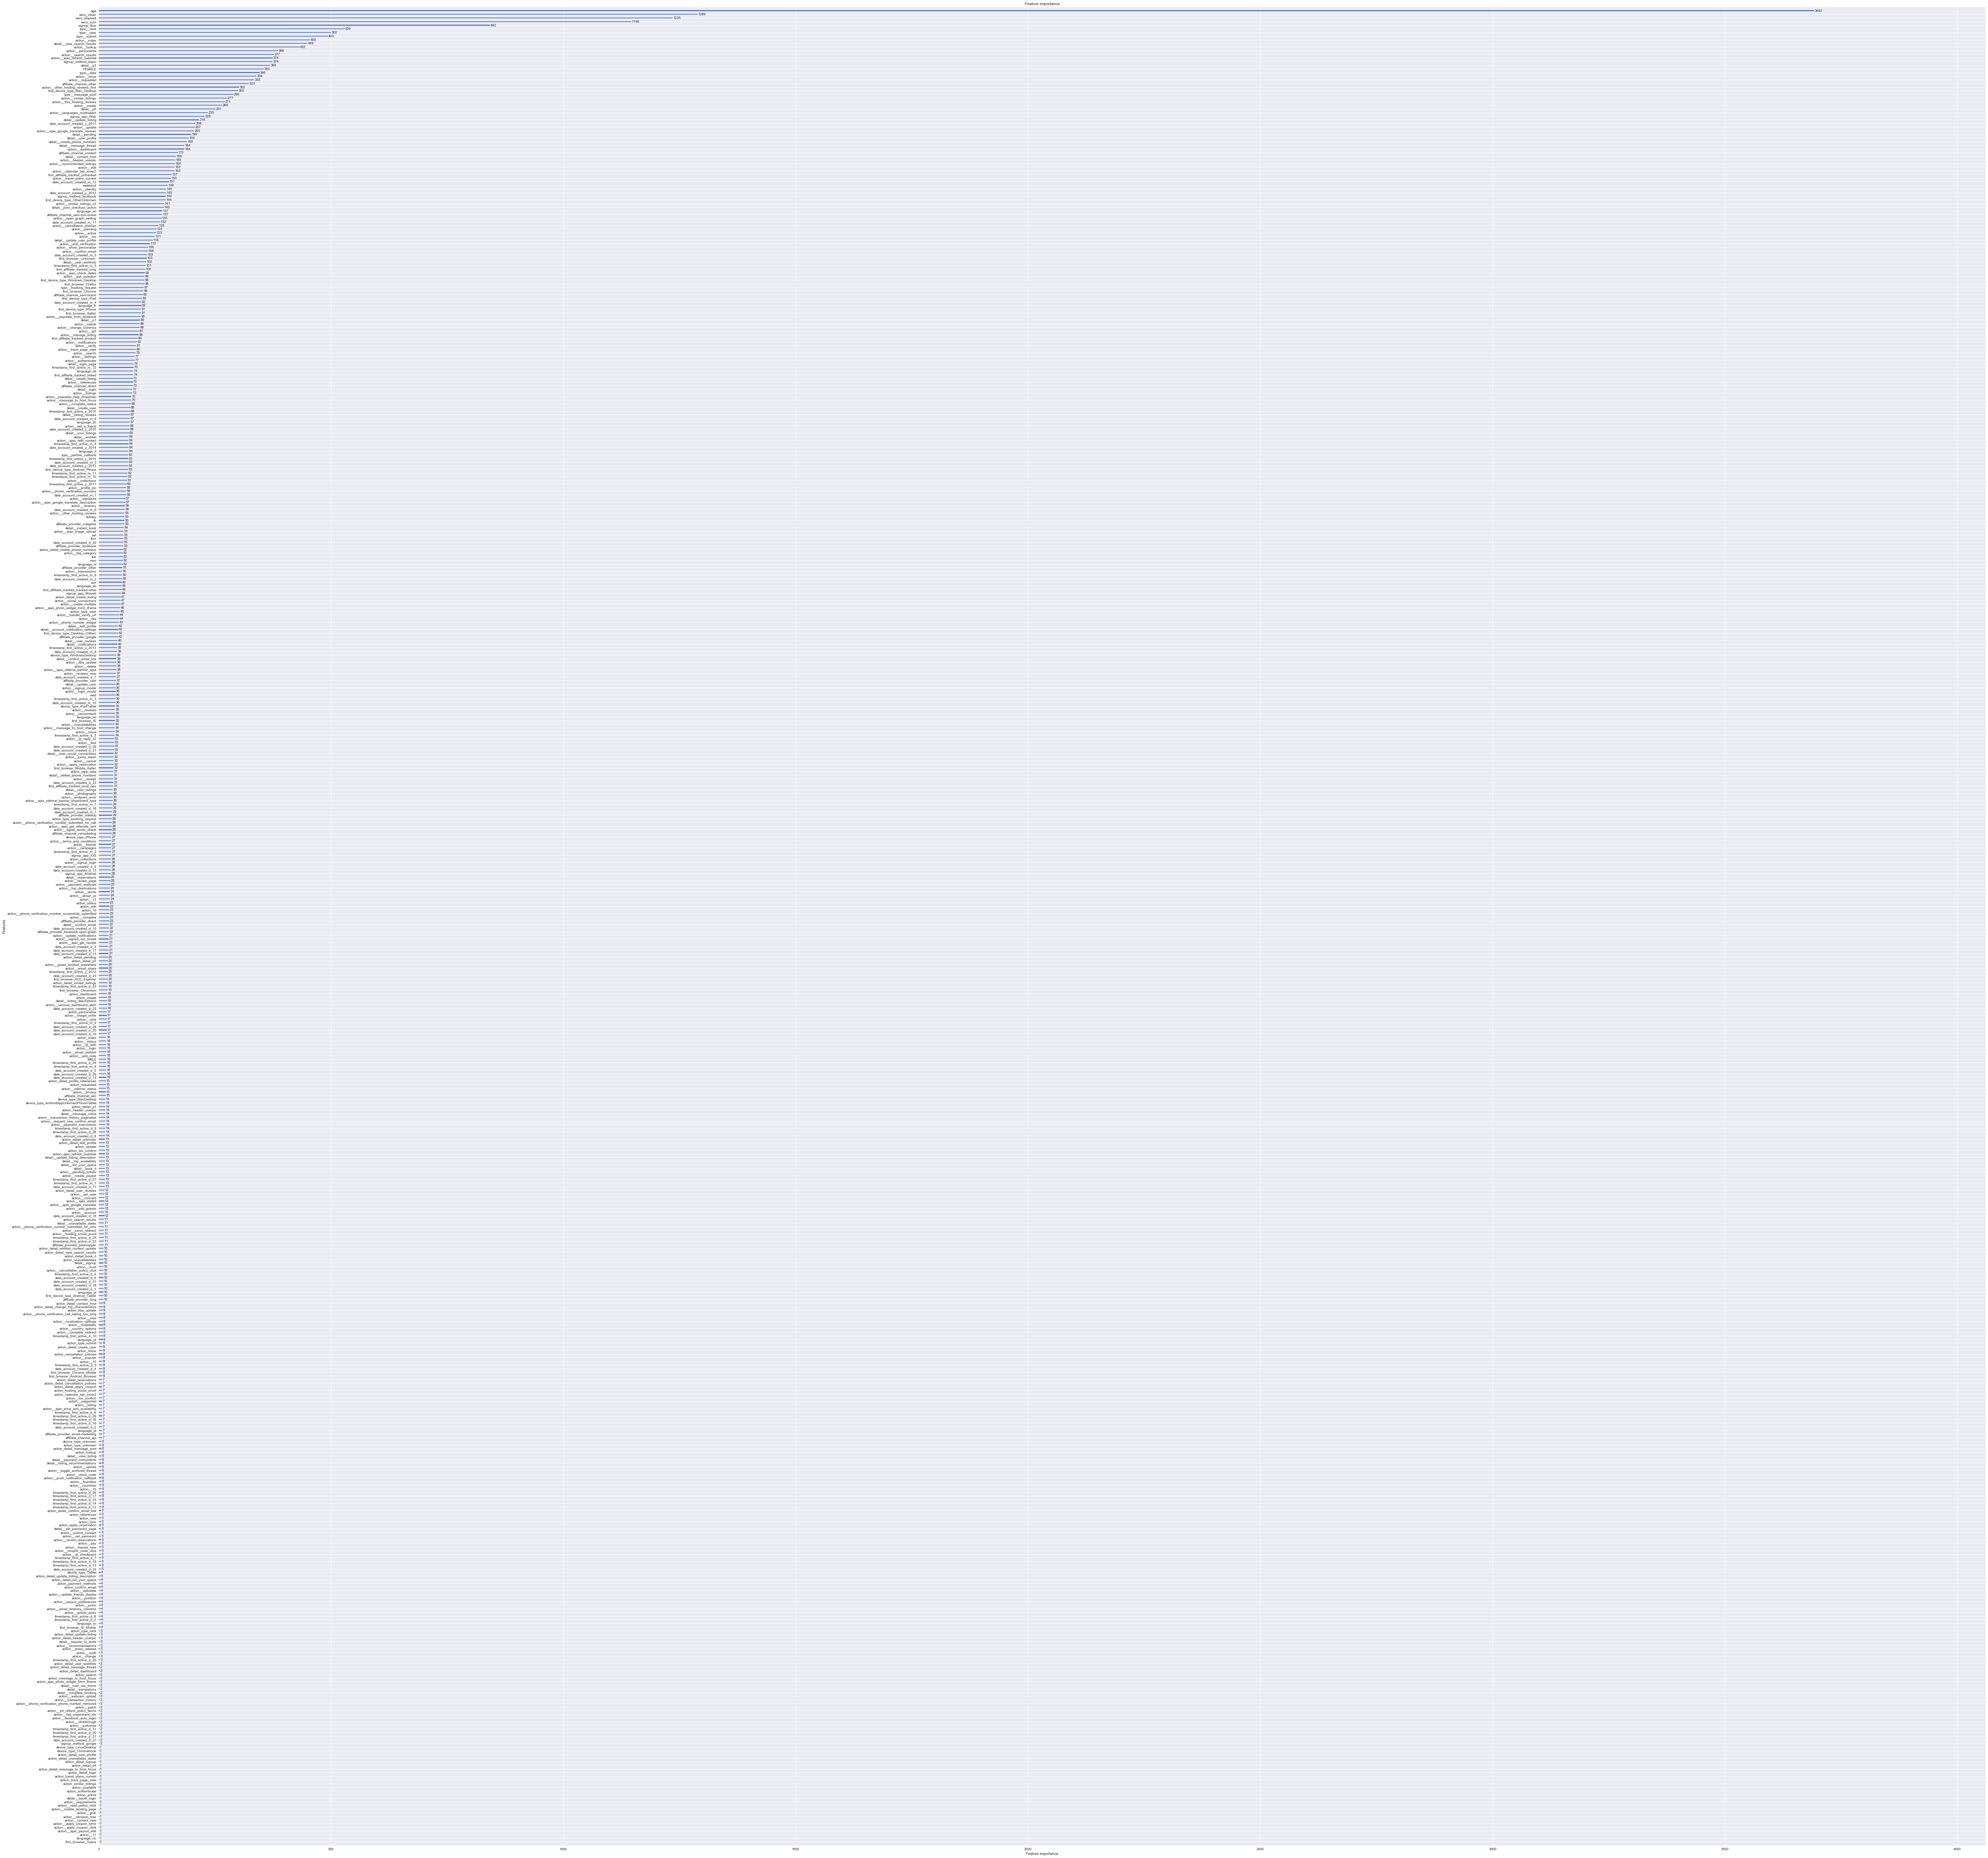

In [104]:
plot_importance(model_lgb, figsize=(100, 100))

### Classification Importance Choice

In [113]:
def model_importance_feature():

    importances = model_lgb.feature_importances_
    importances = pd.DataFrame(importances, columns=["importance"])

    i_c = X.drop(["id", 'country_destination'],axis=1)
    i_c = i_c.columns
    i_c = pd.DataFrame(i_c, columns=["name"])
    f_i = pd.concat([i_c,importances],axis=1)

    f_i_test3 = f_i[f_i['importance'] < 3]

    f_i_test3_l = list(f_i_test3["name"])

    X_test_3 = X.drop(f_i_test3_l,axis=1)
    y_test_3 = y.drop(f_i_test3_l, axis=1)
    
    return X_test_3, y_test_3

### Classification Setting

In [114]:
model_lgb_i = lgb.LGBMClassifier(nthread=3, reg_alpha=1, n_estimators=100)
model_qda_i = QuadraticDiscriminantAnalysis(store_covariance=True)
model_lda_i = LinearDiscriminantAnalysis(n_components=3, solver="svd", store_covariance=True)
model_xg_i = XGBClassifier(nthread=3)
model_age_forest_i = ExtraTreesClassifier(n_estimators=250, random_state=0)

### Classification Analysis Kaggle

In [39]:
submit_kaggle(X_test_75, y_test_75, model_lgb_i, './submission/submit_xg.csv', "id", "country_destination")

model fitting 시작
model fitting 종료
csv file 생성
Successfully submitted to Airbnb New User Bookings

### Classification Importance Check

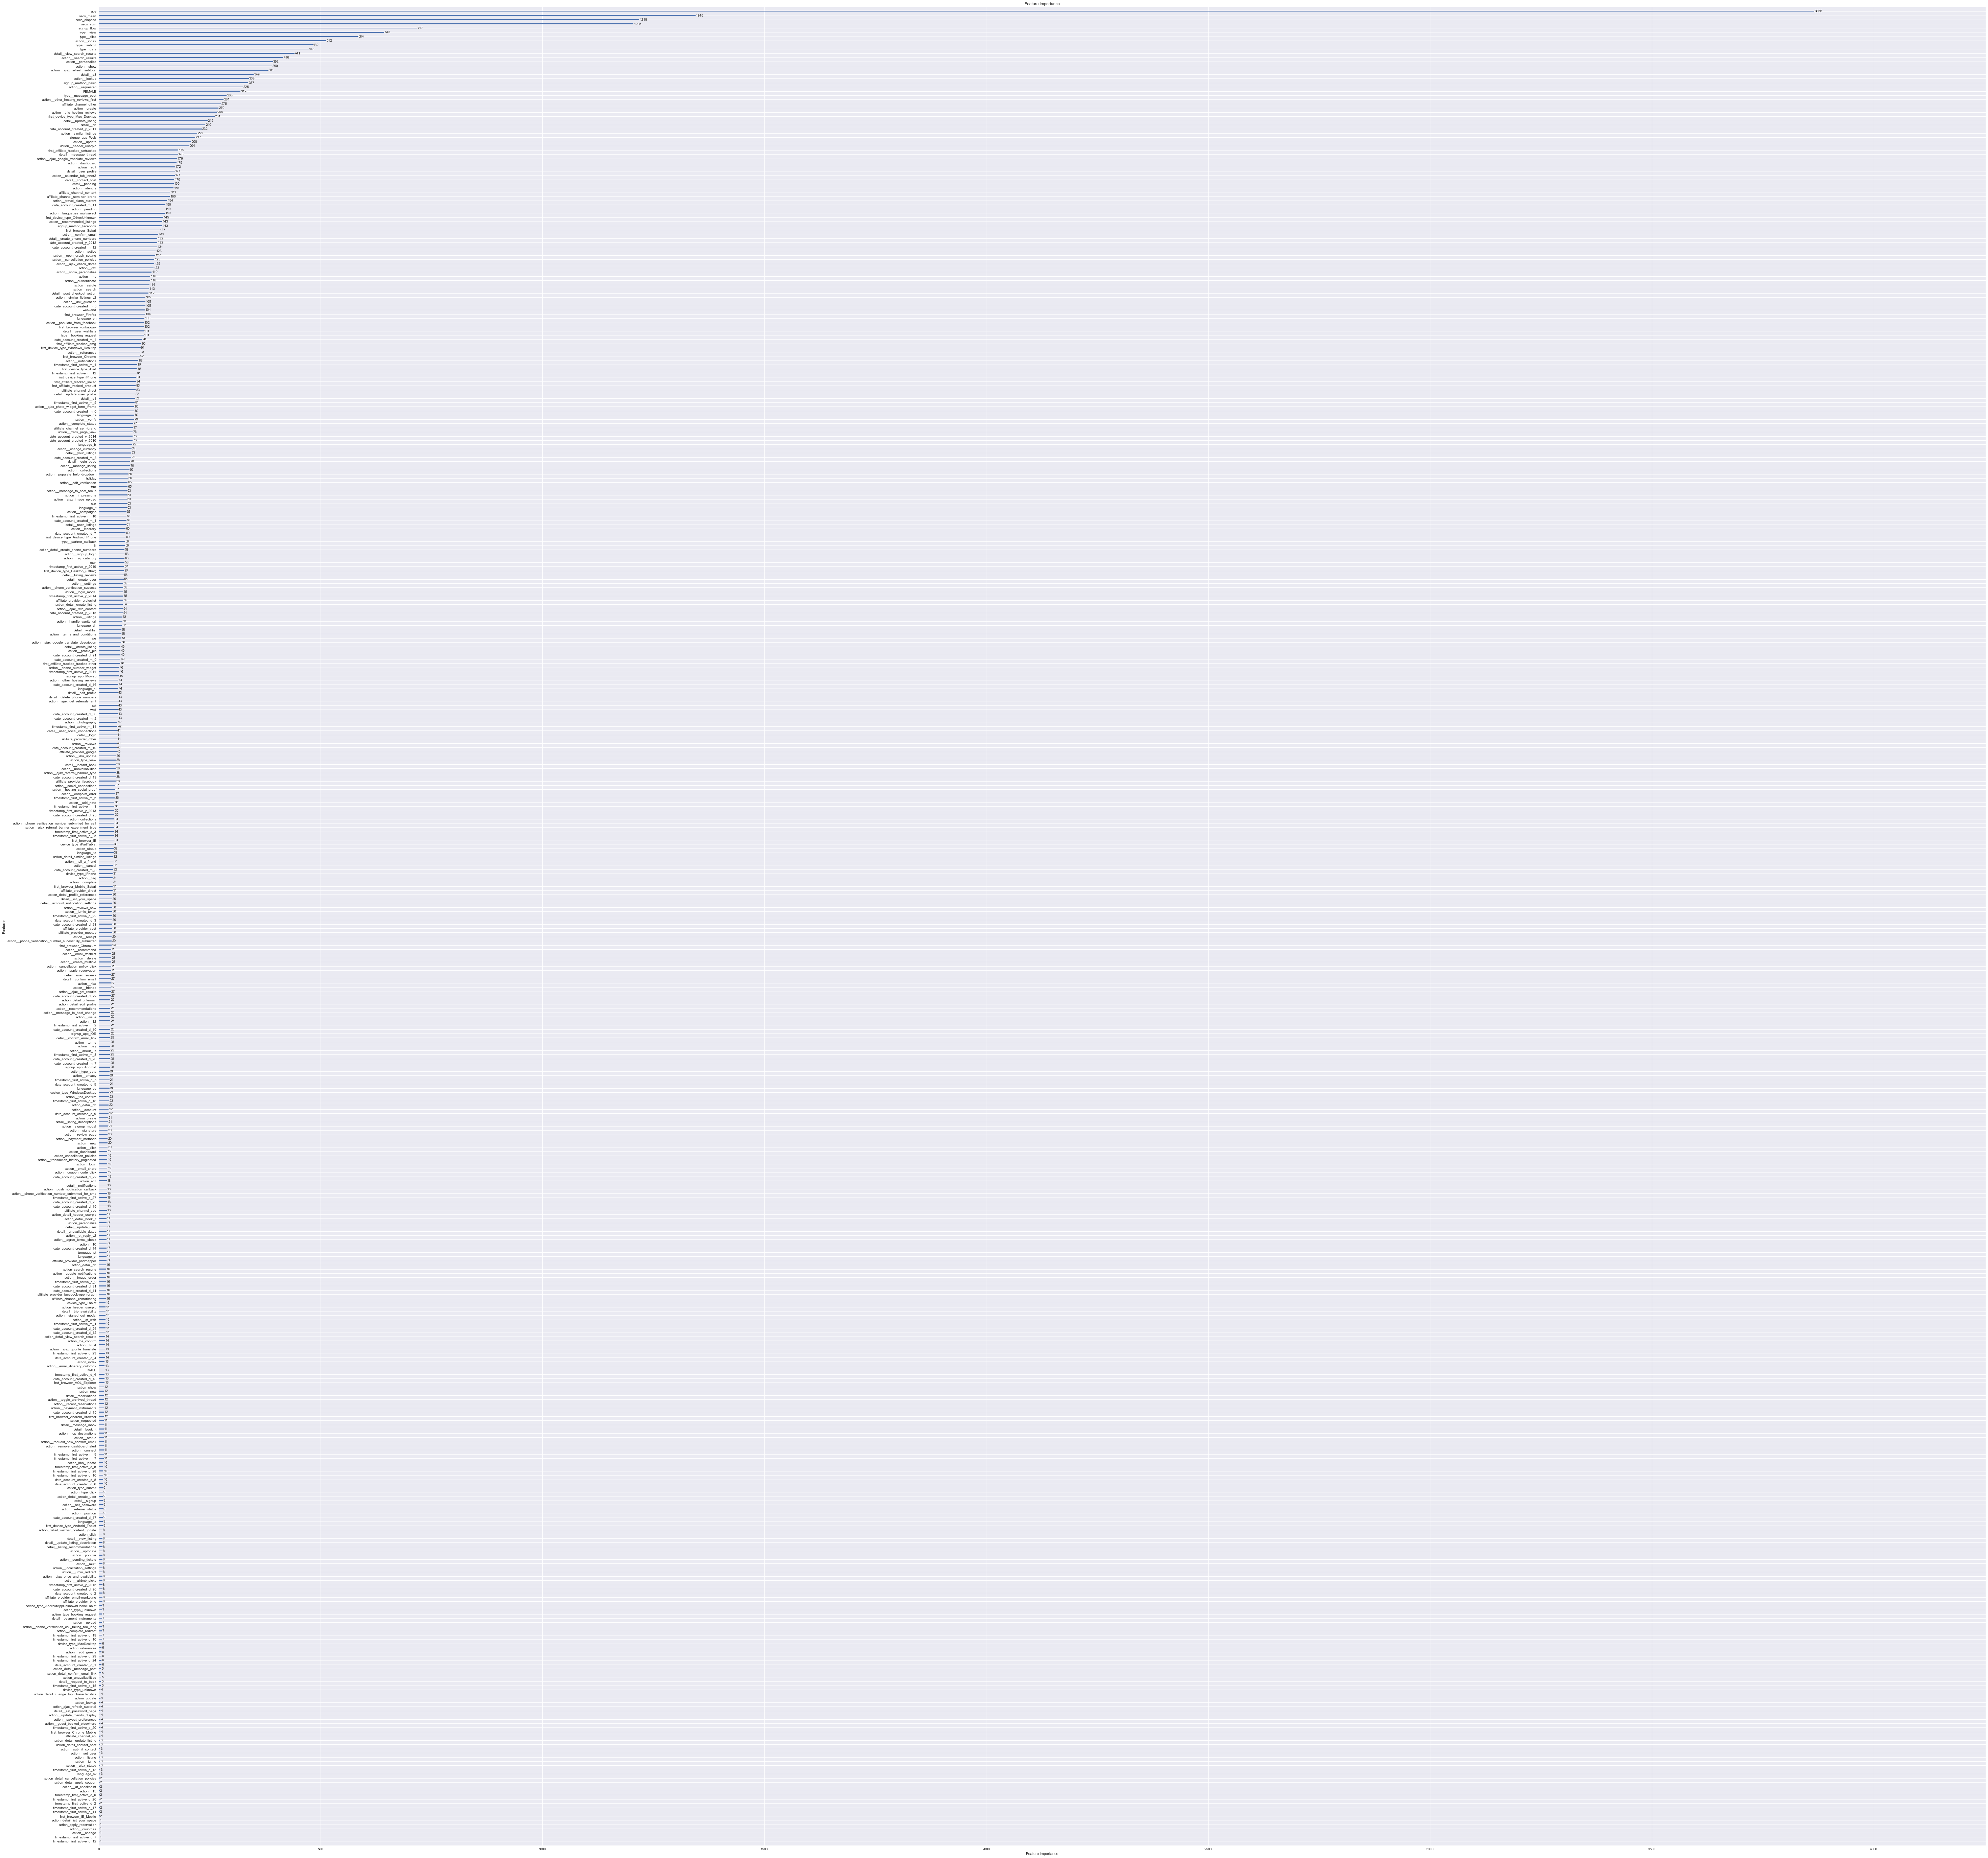

In [29]:
plot_importance(### Classification Importance Check, figsize=(100, 100))

### Kaggle Point = 0.88425

In [17]:
le = preprocessing.LabelEncoder()
y_label = le.fit_transform(X_test_75['country_destination']) 

### accuracy_score

In [18]:
print(accuracy_score(y_label, model_lgb_i.predict(X_test_75.drop(["id", "country_destination"], axis=1))))

0.6540913796899668


### classification_report

In [19]:
print(classification_report(y_label, \
                            model_lgb_i.predict(X_test_75.drop(["id", "country_destination"], axis=1))))

             precision    recall  f1-score   support

          0       1.00      0.01      0.01       539
          1       1.00      0.01      0.02      1428
          2       1.00      0.01      0.02      1061
          3       1.00      0.01      0.02      2249
          4       0.92      0.01      0.02      5024
          5       1.00      0.00      0.01      2324
          6       0.96      0.01      0.02      2835
          7       0.70      0.87      0.78    124549
          8       1.00      0.01      0.03       762
          9       1.00      0.04      0.07       217
         10       0.52      0.49      0.51     62379
         11       1.00      0.01      0.01     10094

avg / total       0.69      0.65      0.60    213461



---

### Classification Analysis Choice Make Data

In [108]:
last_train = X_test_3.to_csv("last_train.csv", index=False)
last_test = y_test_3.to_csv("last_test.csv", index=False)

---

### DecisionTree image

In [63]:
tree1 = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0).fit(X_test_75.drop(['id', 'country_destination'],axis=1), y_label)

In [ ]:
submit_kaggle(X_test_3, y_test_3, tree1, './submission/submit_xg.csv', "id", "country_destination")

In [64]:
def draw_decision_tree(model):
    dot_buf = io.StringIO() 
    export_graphviz(model, out_file=dot_buf, feature_names=X_test_75.columns.drop(['id', 'country_destination']))
    graph = pydot.graph_from_dot_data(dot_buf.getvalue())[0] 
    image = graph.create_png()
    return Image(image)

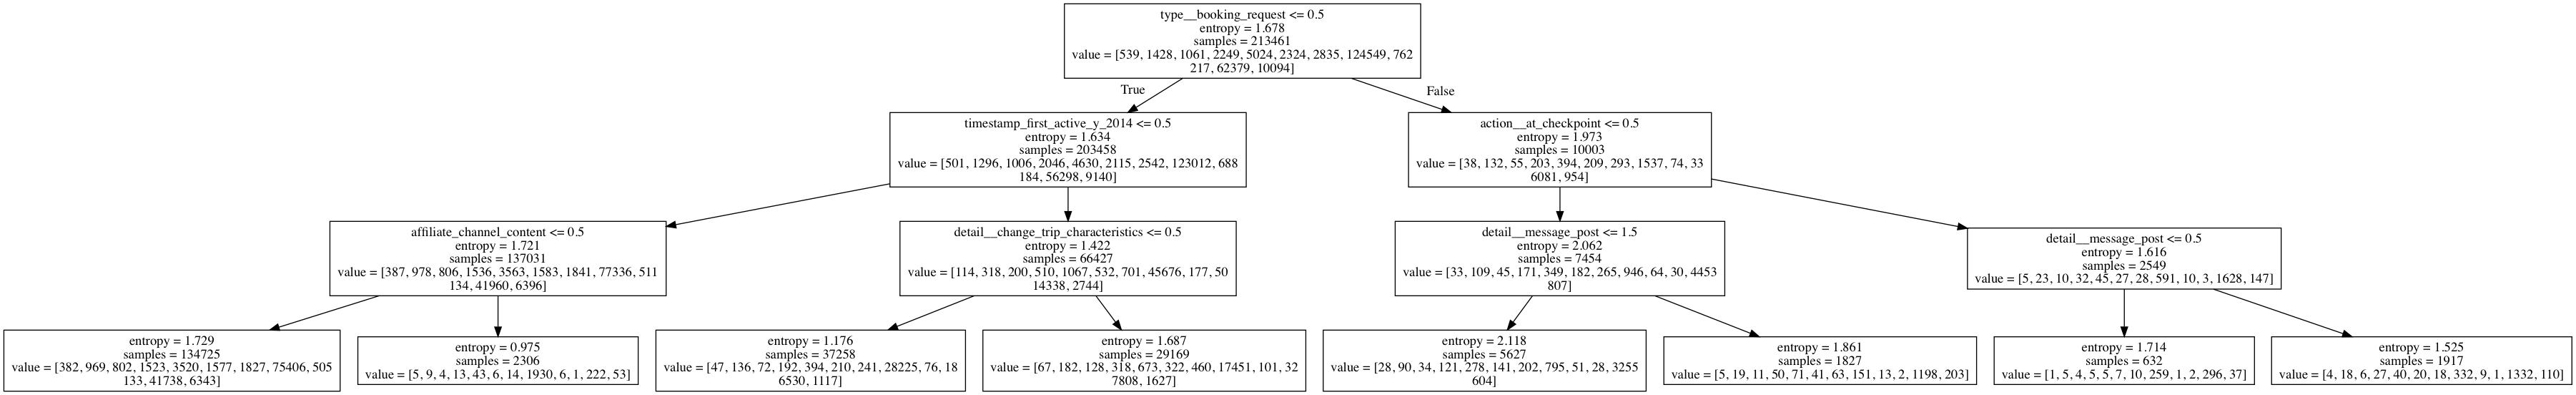

In [66]:
draw_decision_tree(tree1)